Detect Full Rotations, Constants, and Interfaces

In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from tabulate import tabulate
import math
from math import pi
from sklearn.preprocessing import MinMaxScaler
from adtk.detector import QuantileAD
from adtk.visualization import plot

C:\venv\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


Loading and Visualization

In [2]:
# Load dataset
dataset = pd.read_csv('./RJ2250_R6_22_NBIT.csv')

In [3]:
# Load subset dataset
# dataset_subset = pd.read_csv('./Subset of RJ2250_R6_22_NBIT_1_Set.csv')
# dataset_subset

In [4]:
# rename columns and add artificial index
dataset.rename(columns = {list(dataset)[0]:'indexes'}, inplace=True)
dataset.index = pd.date_range("20200101", periods=len(dataset), freq='S')
dataset

,indexes,timestamp_epoch,trace_number,signal_time_ns,signal_amplitude,survey_timestamp_epoch,ticks_ms,depth_m,dip_deg,azimuth_deg,toolface_gyro_deg,toolface_accelerometer_deg,temperature_c,gravity_g
2020-01-01 00:00:00,0,1645293158563,44074,0.00,0.0,1645293158557,580557.0,5.0,31.25,123.06,45.55,282.49,3.76,1.0025
2020-01-01 00:00:01,1,1645293158563,44074,0.25,37.0,1645293158557,580557.0,5.0,31.25,123.06,45.55,282.49,3.76,1.0025
2020-01-01 00:00:02,2,1645293158563,44074,0.50,39.0,1645293158557,580557.0,5.0,31.25,123.06,45.55,282.49,3.76,1.0025
2020-01-01 00:00:03,3,1645293158563,44074,0.75,44.0,1645293158557,580557.0,5.0,31.25,123.06,45.55,282.49,3.76,1.0025
2020-01-01 00:00:04,4,1645293158563,44074,1.00,46.0,1645293158557,580557.0,5.0,31.25,123.06,45.55,282.49,3.76,1.0025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-16 19:03:23,27716603,1645294782553,98207,126.75,36.0,1645294614683,2036683.0,10.0,30.49,124.64,298.91,174.27,8.39,1.0021
2020-11-16 19:03:24,27716604,1645294782553,98207,127.00,36.0,1645294614683,2036683.0,10.0,30.49,124.64,298.91,174.27,8.39,1.0021
2020-11-16 19:03:25,27716605,1645294782553,98207,127.25,36.0,1645294614683,2036683.0,10.0,30.49,124.64,298.91,174.27,8.39,1.0021
2020-11-16 19:03:26,27716606,1645294782553,98207,127.50,36.0,1645294614683,2036683.0,10.0,30.49,124.64,298.91,174.27,8.39,1.0021


In [5]:
# How many Nans are in the dataset
print("Nan Values:")
dataset.isna().sum()

Nan Values:


indexes                       0
timestamp_epoch               0
trace_number                  0
signal_time_ns                0
signal_amplitude              0
survey_timestamp_epoch        0
ticks_ms                      0
depth_m                       0
dip_deg                       0
azimuth_deg                   0
toolface_gyro_deg             0
toolface_accelerometer_deg    0
temperature_c                 0
gravity_g                     0
dtype: int64

In [6]:
# Plot the dataset

# dataset['gravity_g'].plot()
# dataset['toolface_accelerometer_deg'].plot(figsize=(24, 24), title="toolface_accelerometer_deg")

In [7]:
def unique_cols(df):
    """Check if each column has all unique values

    Args:
        df (pandas dataframe): pandas dataset

    Returns:
        array: array length of columns if true then that column has all unique values
    """
    print("Unique Columns:")
    a = df.to_numpy()
    return (a[0] == a).all(0)

unique_cols(dataset)

Unique Columns:


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

Select Rotations, Constants and Interfaces

In [8]:
# Rolling window of the dataset. Devide the dataset into smaller chunks
without_constant = []
with_constant = []
n = 1000000  #chunk row size
list_df = [dataset[i:i+n] for i in range(0,dataset.shape[0],n)]

for i in range(len(list_df)):
    # get min and max in each window
    maxes = np.max(list_df[i]['toolface_accelerometer_deg'].values)
    mins = np.min(list_df[i]['toolface_accelerometer_deg'].values)
    if abs(maxes-mins)>50:
        without_constant.append(list_df[i])
    else:
        with_constant.append(list_df[i])

# for i in without_constant:
#     i['toolface_accelerometer_deg'].plot()
print("length of without_constant out of rolling window (number of df): ", len(without_constant))
# without_constant[-1]

# Concatenate the dataset for with and without constant
without_constant_df = pd.concat(without_constant)
with_constant_df = pd.concat(with_constant)

length of without_constant out of rolling window (number of df):  13


shape of without_constant_df: (13000000, 14)


[<AxesSubplot:>]

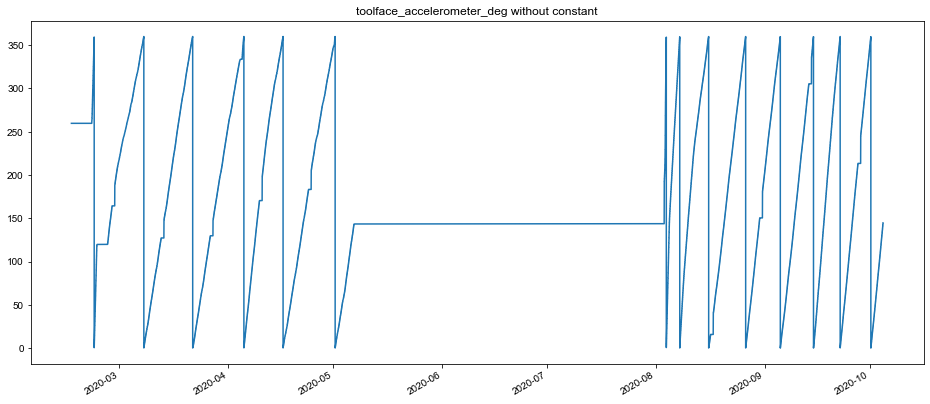

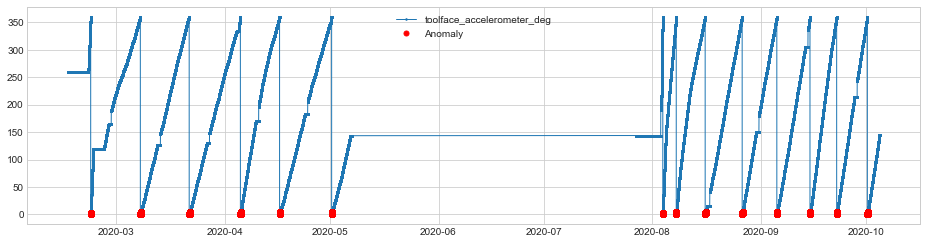

In [9]:
without_constant_df['toolface_accelerometer_deg'].plot(title='toolface_accelerometer_deg without constant',
                                                       figsize=(16,7))
s= without_constant_df['toolface_accelerometer_deg']
print("shape of without_constant_df:", without_constant_df.shape)

# Quantile AD to detect critical points
quantile_ad = QuantileAD(low=0.01,
                        #  high=0.99
                         )
anomalies = quantile_ad.fit_detect(s)

# Visualize the results
plot(s, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker")

In [198]:
# Create a temporary column as index
without_constant_df['index_temp'] = [i for i in range(len(without_constant_df))]
without_constant_df['index_temp']

# Select only the rows with anomalies
out = without_constant_df[anomalies == True][['index_temp', 'toolface_accelerometer_deg']]
# out

# Select critical points from Quantile AD
critical_points =[]
for i, j in enumerate(out['index_temp']):
    if  out['index_temp'][i] - out['index_temp'][i-1] != 1:
        critical_points.append(j)
        
print("critical_points: ",critical_points)


critical_points:  [561408, 1784576, 2988288, 4249856, 5215488, 6498560, 7659328, 7990080, 8702784, 9614656, 10468672, 11285824, 11943232, 12699456]


In [11]:
# Create range of critical points

dfs_rotate = []
for i in range(len(critical_points)-1):
    dfs_rotate.append(without_constant_df[critical_points[i]+1: critical_points[i+1]])
    print("rotate range: ", critical_points[i]+1, critical_points[i+1])

rotate range:  561409 1784576
rotate range:  1784577 2988288
rotate range:  2988289 4249856
rotate range:  4249857 5215488
rotate range:  5215489 6498560
rotate range:  6498561 7659328
rotate range:  7659329 7990080
rotate range:  7990081 8702784
rotate range:  8702785 9614656
rotate range:  9614657 10468672
rotate range:  10468673 11285824
rotate range:  11285825 11943232
rotate range:  11943233 12699456


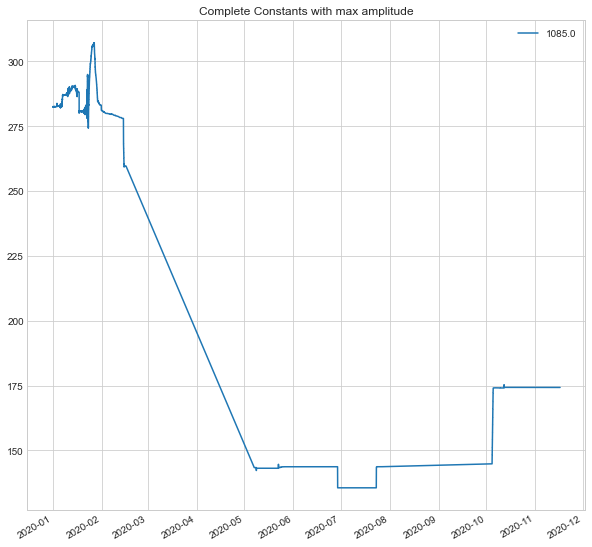

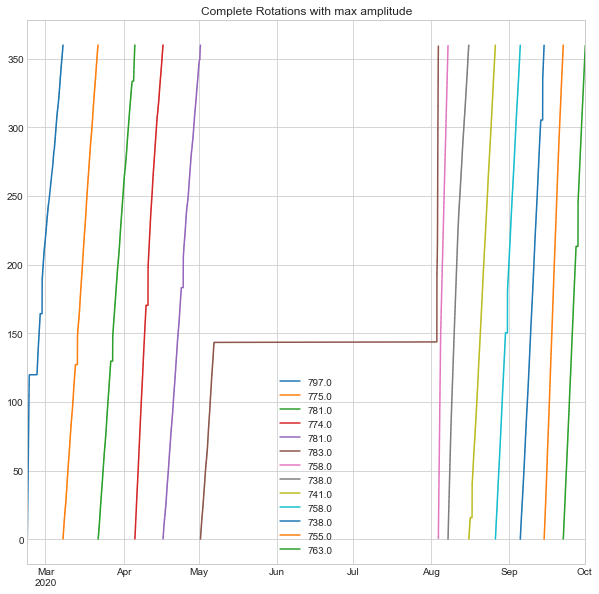

In [12]:
# Plot Complete Constants and select Interfaces
legends = []
constant_max_amplitude = []
fig, ax = plt.subplots()
with_constant_df['toolface_accelerometer_deg'].plot(title='Complete Constants with max amplitude', figsize=(10,10))
legends.append(with_constant_df['signal_amplitude'].max())
constant_max_amplitude.append(with_constant_df[with_constant_df['signal_amplitude'] == with_constant_df['signal_amplitude'].max()])
ax.legend(legends);
        
# Plot Complete Rotations and select Interfaces
legends = []
rotate_max_amplitude = []
fig, ax = plt.subplots()
for df in dfs_rotate:
    df['toolface_accelerometer_deg'].plot(title='Complete Rotations with max amplitude', figsize=(10,10))
    legends.append(df['signal_amplitude'].max())
    rotate_max_amplitude.append(df[df['signal_amplitude'] == df['signal_amplitude'].max()])
    ax.legend(legends);

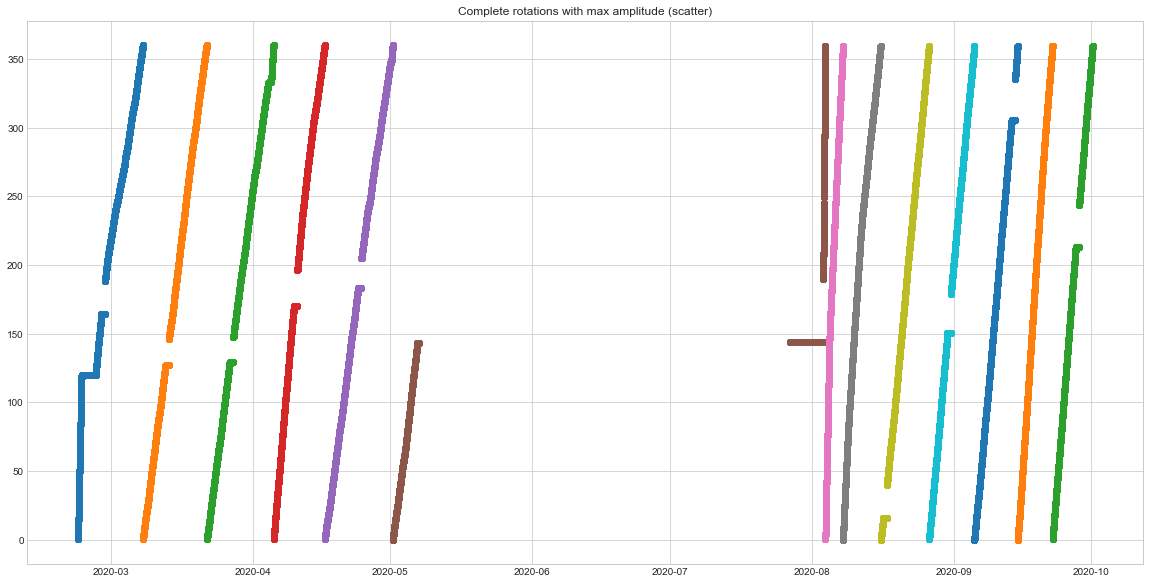

In [13]:
# Scatter Plot for Complete Rotations
fig, ax = plt.subplots(figsize=(20, 10))
for df in dfs_rotate:
    plt.scatter(x=df.index, y=df['toolface_accelerometer_deg'])
    plt.title('Complete rotations with max amplitude (scatter)')

In [14]:
# Show Interafaces values for constants
print("Max amplitude for constants:\n")
for max_amplitude_points in constant_max_amplitude:
    print(max_amplitude_points.to_markdown())
    print("*******"*20)
    print("*******"*20)

Max amplitude for constants:

|                     |   indexes |   timestamp_epoch |   trace_number |   signal_time_ns |   signal_amplitude |   survey_timestamp_epoch |   ticks_ms |   depth_m |   dip_deg |   azimuth_deg |   toolface_gyro_deg |   toolface_accelerometer_deg |   temperature_c |   gravity_g |
|:--------------------|----------:|------------------:|---------------:|-----------------:|-------------------:|-------------------------:|-----------:|----------:|----------:|--------------:|--------------------:|-----------------------------:|----------------:|------------:|
| 2020-01-06 19:40:51 |    502851 |       1.64529e+12 |          45056 |            16.75 |               1085 |              1.64529e+12 |     610025 |         5 |     31.58 |        123.24 |               46.79 |                       283.55 |            3.85 |      1.0043 |
****************************************************************************************************************************************

In [15]:
# Show Interafaces values for each Rotation
print("Max amplitude for rotations:\n")
for max_amplitude_points in rotate_max_amplitude:
    print(max_amplitude_points.to_markdown())
    print("*******"*20)
    print("*******"*20)

Max amplitude for rotations:

|                     |    indexes |   timestamp_epoch |   trace_number |   signal_time_ns |   signal_amplitude |   survey_timestamp_epoch |   ticks_ms |   depth_m |   dip_deg |   azimuth_deg |   toolface_gyro_deg |   toolface_accelerometer_deg |   temperature_c |   gravity_g |   index_temp |
|:--------------------|-----------:|------------------:|---------------:|-----------------:|-------------------:|-------------------------:|-----------:|----------:|----------:|--------------:|--------------------:|-----------------------------:|----------------:|------------:|-------------:|
| 2020-02-26 23:03:24 | 4.9214e+06 |       1.64529e+12 |          53686 |               15 |                797 |              1.64529e+12 |     868932 |         5 |     30.32 |        124.01 |              256.74 |                       132.73 |            4.99 |       1.002 |       921404 |
****************************************************************************************

Fit a Line to a Window and Compute Degree

angle:  4.225951818628062


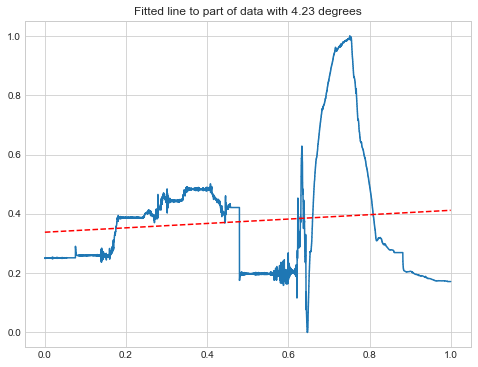

In [16]:
# Fit a line to a window of dataset

scaler = MinMaxScaler()
x = dataset['toolface_accelerometer_deg'][0:3000000].values
x = scaler.fit_transform(x.reshape(-1, 1))
y = np.linspace(0, 1, len(x))
x=x.ravel()
best_fit_line = np.poly1d(np.polyfit(y, x, 1))(y)
# print("best_fit_line: ", best_fit_line)

# slope = (y[-1] - y[0]) / (x[-1] - x[0])
# angle = np.arctan(slope)
# print ('slope: ' + str(slope))
# print ('angle: ' + str(angle))

angle = np.rad2deg(np.arctan2(1, best_fit_line[-1] - best_fit_line[0] ))
angle = abs(angle-90)
print("angle: ", angle)

plt.figure(figsize=(8,6))
plt.plot(y, x)
plt.plot(y, best_fit_line, '--', color='r')
plt.title(f'Fitted line to part of data with {angle:.2f} degrees')
plt.show()

Some unused methods

In [250]:
avg_critical_points = critical_points[1] - critical_points[0]
print(avg_critical_points)
# Plot Complete Rotations and select Interfaces
legends = []
rotate_max_amplitude = []
separation = []
for i in range(len(without_constant_df)-avg_critical_points):
    if without_constant_df['indexes'][i+avg_critical_points] - without_constant_df['indexes'][i] > avg_critical_points*2:
        separation.append(i+1)

1223168


In [251]:
# takeClosest = lambda num,collection:min(collection,key=lambda x:abs(x-num))
separation_points = []
for i in range(len(separation)-1):
    if separation[i+1] - separation[i] > 1:
        separation_points.append(i)
    else:
        separation_points = [0, separation[-1]]
separation_points


[0, 7000000]

In [252]:
# df['toolface_accelerometer_deg'].plot(title='Complete Rotations with max amplitude', figsize=(10,10))
# legends.append(df['signal_amplitude'].max())
# rotate_max_amplitude.append(df[df['signal_amplitude'] == df['signal_amplitude'].max()])
# ax.legend(legends);
# df_rotations = []
# for i in separation_points:
#     df_rotations.append(without_constant_df[:i])
dfs_rotate = []
for i in range(len(separation_points)-1):
    dfs_rotate.append(without_constant_df[separation_points[i]: separation_points[i+1]])
    print("rotate range: ", i)
    
dfs_rotate.append(without_constant_df[separation_points[-1]: ])
dfs_rotate


rotate range:  0


[                      indexes  timestamp_epoch  trace_number  signal_time_ns  \
 2020-02-16 07:06:40   4000000    1645293392923         51886           64.00   
 2020-02-16 07:06:41   4000001    1645293392923         51886           64.25   
 2020-02-16 07:06:42   4000002    1645293392923         51886           64.50   
 2020-02-16 07:06:43   4000003    1645293392923         51886           64.75   
 2020-02-16 07:06:44   4000004    1645293392923         51886           65.00   
 ...                       ...              ...           ...             ...   
 2020-05-07 07:33:15  10999995    1645293803083         65558           46.75   
 2020-05-07 07:33:16  10999996    1645293803083         65558           47.00   
 2020-05-07 07:33:17  10999997    1645293803083         65558           47.25   
 2020-05-07 07:33:18  10999998    1645293803083         65558           47.50   
 2020-05-07 07:33:19  10999999    1645293803083         65558           47.75   
 
                      sign

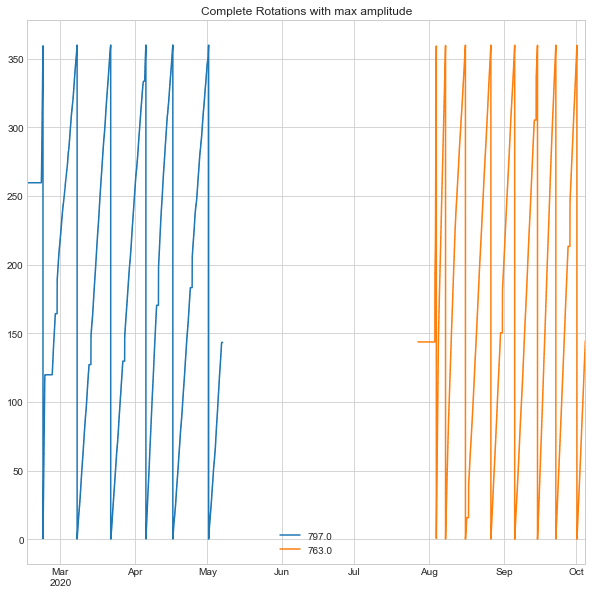

In [253]:
# Plot Complete Rotations and select Interfaces
legends = []
rotate_max_amplitude = []
fig, ax = plt.subplots()
for df in dfs_rotate:
    df['toolface_accelerometer_deg'].plot(title='Complete Rotations with max amplitude', figsize=(10,10))
    legends.append(df['signal_amplitude'].max())
    rotate_max_amplitude.append(df[df['signal_amplitude'] == df['signal_amplitude'].max()])
    ax.legend(legends);

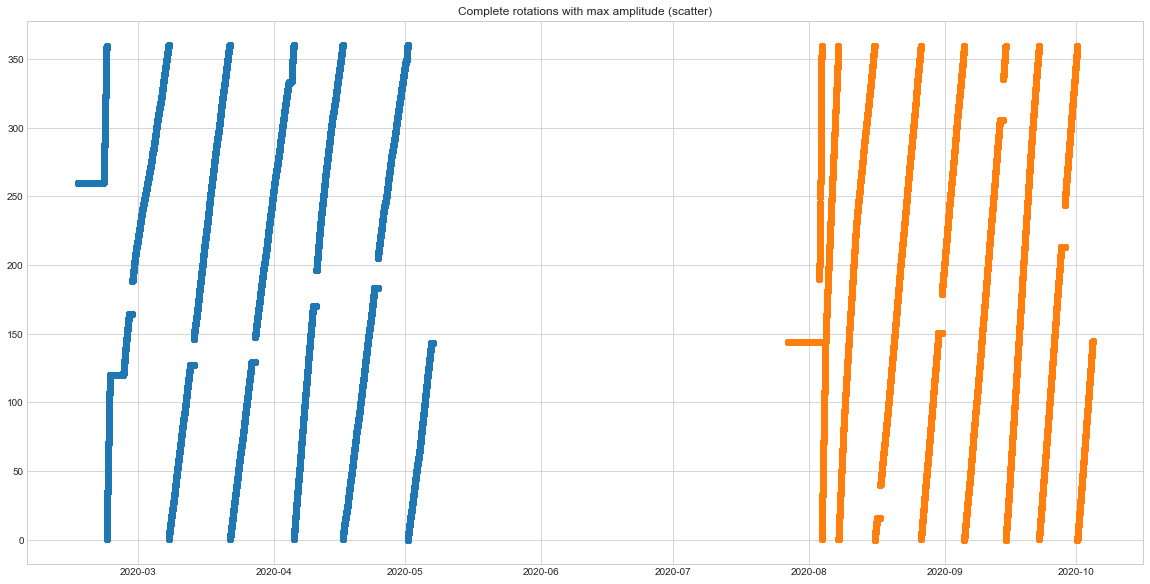

In [254]:
# Scatter Plot for Complete Rotations
fig, ax = plt.subplots(figsize=(20, 10))
for df in dfs_rotate:
    plt.scatter(x=df.index, y=df['toolface_accelerometer_deg'])
    plt.title('Complete rotations with max amplitude (scatter)')

In [255]:
# Show Interafaces values for each Rotation
print("Max amplitude for rotations:\n")
for max_amplitude_points in rotate_max_amplitude:
    print(max_amplitude_points.to_markdown())
    print("*******"*20)
    print("*******"*20)

Max amplitude for rotations:

|                     |    indexes |   timestamp_epoch |   trace_number |   signal_time_ns |   signal_amplitude |   survey_timestamp_epoch |   ticks_ms |   depth_m |   dip_deg |   azimuth_deg |   toolface_gyro_deg |   toolface_accelerometer_deg |   temperature_c |   gravity_g |   index_temp |
|:--------------------|-----------:|------------------:|---------------:|-----------------:|-------------------:|-------------------------:|-----------:|----------:|----------:|--------------:|--------------------:|-----------------------------:|----------------:|------------:|-------------:|
| 2020-02-26 23:03:24 | 4.9214e+06 |       1.64529e+12 |          53686 |               15 |                797 |              1.64529e+12 |     868932 |         5 |     30.32 |        124.01 |              256.74 |                       132.73 |            4.99 |       1.002 |       921404 |
****************************************************************************************

In [256]:
# Old used method, close to the previous method. 

# s= dataset['toolface_accelerometer_deg']
# dataset.index

# quantile_ad = QuantileAD(high=0.999, low=0.001)
# # quantile_ad = QuantileAD(high=0.999)
# anomalies = quantile_ad.fit_detect(s)

# plot(s, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");

# out = dataset[anomalies == True][['indexes', 'toolface_accelerometer_deg']]
# # c = dataset[dataset['indexes'] == 4540100].indexes
# # v = dataset[dataset['indexes'] == 4561400].indexes
# # dataset.iloc[int(c.values):int(v.values)]['toolface_accelerometer_deg'].plot()
# out

# (dataset[anomalies == True]['toolface_accelerometer_deg'] ==359.9).sum()

# critical_points =[]
# for i, j in enumerate(out['indexes']):
#     if  out['indexes'][i] - out['indexes'][i-1] != 1:
#         critical_points.append(j)
# critical_points.insert(0,0)
# critical_points

# for i in range(len(critical_points)-1):
#     # print(i)
#     print(critical_points[i], critical_points[i+1])

# dfs_constant = []
# dfs_rotate = []
# dfs_constant.append(dataset[critical_points[-1]+1: ])
# for i in range(len(critical_points)-1):
#     # print(critical_points[i]+1, critical_points[i+1])
#     if i == 0 :
#         dfs_constant.append(dataset[critical_points[i]: critical_points[i+1]])
#         print(critical_points[i], critical_points[i+1])
#     # elif i == len(critical_points)-1:
#     #     dfs_constant.append(dataset[critical_points[i]: ])
#     #     print(critical_points[i])
#     elif (critical_points[i+1] - critical_points[i]) > dataset.shape[0]*0.2:
#             dfs_constant.append(dataset[critical_points[i]+1: critical_points[i+1]])
#             print(critical_points[i]+1, critical_points[i+1])
#     else:
#         dfs_rotate.append(dataset[critical_points[i]+1: critical_points[i+1]])
#         print("rotate: ",critical_points[i]+1, critical_points[i+1])

# dfs_constant[0]

# #Constants
# legends = []
# constant_max_amplitude = []
# fig, ax = plt.subplots()
# for df in dfs_constant:
#     df['toolface_accelerometer_deg'].plot(title='Constants with max amplitude', figsize=(10,10))
#     legends.append(df['signal_amplitude'].max())
#     constant_max_amplitude.append(df[df['signal_amplitude'] == df['signal_amplitude'].max()])
#     ax.legend(legends);

# for max_amplitude_points in constant_max_amplitude:
#     print(max_amplitude_points.to_markdown())

# #Complete Rotation
# legends = []
# rotate_max_amplitude = []
# fig, ax = plt.subplots()
# for df in dfs_rotate:
#     df['toolface_accelerometer_deg'].plot(title='Complete rotations with max amplitude', figsize=(10,10))
#     legends.append(df['signal_amplitude'].max())
#     rotate_max_amplitude.append(df[df['signal_amplitude'] == df['signal_amplitude'].max()])
#     ax.legend(legends);

# # rotate_max_amplitude
# print("Max amplitude for rotations:")
# for max_amplitude_points in rotate_max_amplitude:
#     print(max_amplitude_points.to_markdown())
#     print("*******"*20)
#     print("*******"*20)

# print("Max amplitude for constants:")
# for max_amplitude_points in constant_max_amplitude:
#     print(max_amplitude_points.to_markdown())
#     print("*******"*20)
#     print("*******"*20)

In [257]:
# # Create a Series with the same index as df, where the consecutive values are unique
# g = dataset['toolface_accelerometer_deg'].ne(dataset['toolface_accelerometer_deg'].shift()).cumsum()

# # use g with groupby to count the consecutive values and then create a Boolean using > 4 (will represent 2 minutes, when the time interval is 30 seconds).
# consecutive_data = dataset[['indexes', 'toolface_accelerometer_deg']][dataset['toolface_accelerometer_deg'].groupby(g).transform('count') > 100000]
# consecutive_data['toolface_accelerometer_deg'].plot()

# dfA = dataset[~dataset['indexes'].isin(consecutive_data['indexes'])]
# dfA

# dfA['toolface_accelerometer_deg'].plot()

# dataset['result'] = dataset['toolface_accelerometer_deg'].le(dataset['toolface_accelerometer_deg'].shift(periods=10))
# #| np.isclose(dataset['toolface_accelerometer_deg'], dataset['toolface_gyro_deg'])
# dataset[dataset['result']]

# x = dataset[dataset['result']]
# x['toolface_accelerometer_deg'].plot()

In [258]:
# # Create function for detect pandas dataframe increase and constant
# def detect_pandas_increase(df):
#     """
#     Detect pandas dataframe increase and constant
#     :param df: pandas dataframe
#     :return: pandas dataframe
#     """
#     # create empty list
#     increase = []
#     constant = []
#     # loop for dataframe
#     for i in range(len(df)-1):
#         # if dataframe is increase
#         if df.iloc[i+1] > df.iloc[i]:
#             # append increase
#             increase.append(df.iloc[i])
#         # if dataframe is constant
#         else:
#             # append constant
#             constant.append(df.iloc[i])
#     # create dataframe
#     df_increase = pd.DataFrame(increase, columns=['Increase'])
#     df_constant = pd.DataFrame(constant, columns=['Constant'])
#     # concat increase and constant
#     df_increase = pd.concat([df_increase, df_constant], axis=1)
#     # return dataframe
#     return df_increase, df_constant

# df_increase, df_constant = detect_pandas_increase(dataset['toolface_accelerometer_deg'])
# df_increase['Increase'].plot()